In [2]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
nltk.download('stopwords')

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Importing the dataset to use for performing analysis

In [4]:
#importing the training data
air_data=pd.read_csv('airline_sentiment_analysis.csv')
air_data.head(10)

,Unnamed: 0,airline_sentiment,text
0,1,positive,@VirginAmerica plus you've added commercials t...
1,3,negative,@VirginAmerica it's really aggressive to blast...
2,4,negative,@VirginAmerica and it's a really big bad thing...
3,5,negative,@VirginAmerica seriously would pay $30 a fligh...
4,6,positive,"@VirginAmerica yes, nearly every time I fly VX..."
5,8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D"
6,9,positive,"@VirginAmerica it was amazing, and arrived an ..."
7,11,positive,@VirginAmerica I &lt;3 pretty graphics. so muc...
8,12,positive,@VirginAmerica This is such a great deal! Alre...
9,13,positive,@VirginAmerica @virginmedia I'm flying your #f...


###Splitting dataset into training and test set


In [7]:
#split the dataset  
#train dataset
train_reviews=air_data.text[:10000]
train_sentiments=air_data.airline_sentiment	[:10000]
#test dataset
test_reviews=air_data.text[10000:]
test_sentiments=air_data.airline_sentiment[10000:]

###Text Normalization
To separate a statement into words, we utilise the word tokenize () method.

In [8]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

###Removing HTML strips and noise text

Here in data head we can see some html code so first we need to clean that html strips. Also removing some noisy texts along with square brackets.

In [10]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
air_data['text']=air_data['text'].apply(denoise_text)

###Remove Special Characters
Because we’re working with English-language evaluations in our dataset, we need to make sure that any special characters are deleted.

In [11]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
air_data['text']=air_data['text'].apply(remove_special_characters)

###Removing stopwords and normalization
Stop words are words that have little or no meaning, especially when synthesising meaningful aspects from the text.

In [12]:
#set stopwords to english
stop=set(stopwords.words('english'))

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
air_data['text']=air_data['text'].apply(remove_stopwords)

##Text stemming
###Stemming is a technique for eliminating affixes from words in order to retrieve the base form.

In [13]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
air_data['text']=air_data['text'].apply(simple_stemmer)

###Normalized train and test reviews

In [14]:
#normalized train reviews
norm_train_reviews=air_data.text[:10000]
#Normalized test reviews
norm_test_reviews=air_data.text[10000:]

###Bags of words model

It is used to convert text documents to numerical vectors or bag of words.

In [15]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (10000, 137190)
BOW_cv_test: (1541, 137190)


###Labeling the sentiment text and splitting it into training and test set 

In [17]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(air_data['airline_sentiment'])

#Spliting the sentiment data
train_sentiments=sentiment_data[:10000]
test_sentiments=sentiment_data[10000:]

##Logistic Regression

###Modelling the dataset
Building model based on logistic regression for bag of words and tfidf features

In [18]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


###Predicitng on test dataset

In [19]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)

[0 0 0 ... 0 0 0]


###Accuracy of the model

In [20]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)

lr_bow_score : 0.8825438027255029


##Naive Bayes
###Modelling the dataset
Building model based on Naive Baiyes for bag of words and tfidf features

In [21]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


###Predicting on test dataset

In [22]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)

[0 0 0 ... 0 0 0]


###Accuracy of model

In [23]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)

mnb_bow_score : 0.8689162881245944


##Support vector machines
###Modelling the dataset
Building model based on Linear support vector machines for bag of words and tfidf features

In [24]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(cv_train_reviews,train_sentiments)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


###Predicting on test dataset

In [25]:
#Predicting the model for bag of words
svm_bow_predict=svm.predict(cv_test_reviews)
print(svm_bow_predict)

[0 0 0 ... 0 0 0]


###Accuracy of model

In [26]:
#Accuracy score for bag of words
svm_bow_score=accuracy_score(test_sentiments,svm_bow_predict)
print("svm_bow_score :",svm_bow_score)

svm_bow_score : 0.8838416612589228


##Neural Network
###Modelling the dataset
Building model based on a neural network 

In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)  #Initialize the tokenizer with a 5000 word limit. This is the number of words we would like to encode.
tokenizer.fit_on_texts(train_reviews)  #We call fit_on_texts to create associations of words and numbers as shown
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(train_reviews)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [28]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding

embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length,        
                                     input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           334784    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 351,435
Trainable params: 351,435
Non-trainable params: 0
_________________________________________________________________
None


###Training the model

In [30]:
history = model.fit(padded_sequence, train_sentiments,
                  validation_split=0.2, epochs=5, batch_size=64)

Epoch 1/5
125/125 [==============================] - 33s 263ms/step - loss: 0.2746 - accuracy: 0.8934 - val_loss: 0.2092 - val_accuracy: 0.9165
Epoch 2/5
125/125 [==============================] - 31s 245ms/step - loss: 0.1909 - accuracy: 0.9227 - val_loss: 0.2136 - val_accuracy: 0.9150
Epoch 3/5
125/125 [==============================] - 30s 237ms/step - loss: 0.1628 - accuracy: 0.9385 - val_loss: 0.2137 - val_accuracy: 0.9125
Epoch 4/5
125/125 [==============================] - 33s 265ms/step - loss: 0.1330 - accuracy: 0.9513 - val_loss: 0.2105 - val_accuracy: 0.9160
Epoch 5/5
125/125 [==============================] - 30s 237ms/step - loss: 0.1204 - accuracy: 0.9550 - val_loss: 0.2412 - val_accuracy: 0.9160


###Accuracy of Model

In [31]:
encoded_docs_test = tokenizer.texts_to_sequences(test_reviews)
padded_sequence_test = pad_sequences(encoded_docs_test, maxlen=200)
test_loss, test_acc = model.evaluate(padded_sequence_test, test_sentiments)

49/49 [==============================] - 2s 32ms/step - loss: 0.1639 - accuracy: 0.9429


In [32]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

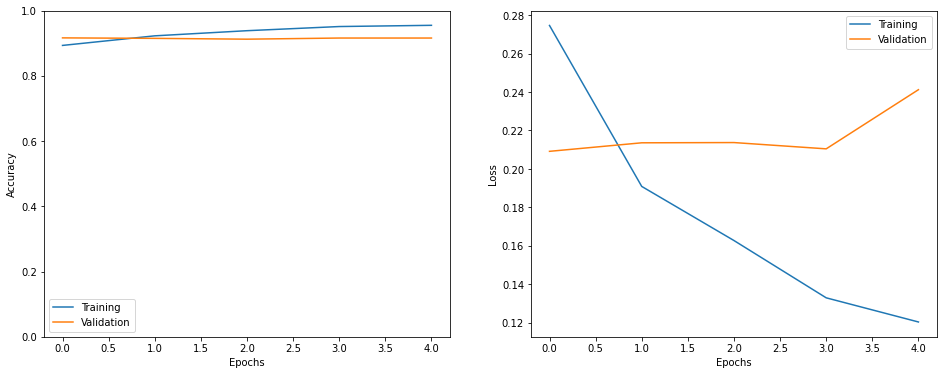

In [33]:
show_history(history)